## Simple example of importing a function on a non uniform grid

ApproxFun generally needs, or needs to be able to evaluate, function values on the Chebyshev grid.  There are other methods, but here is one to use when you have data that is not on a Chebyshev grid.  It uses [The AAA algorithm for rational approximation](http://arxiv.org/abs/1612.00337) (from the registered package **BaryRational**) to first form a rational approximation to the data.  Then it uses that approximation to evaluate on a Chebyshev grid and then transforms those values to Chebyshev expansion coefficients.  Finally, it uses those coefficients to create an ApproxFun Fun.

This example first constructs the Fun from a random grid and plots it against the true value.  Next the first and second derivatives are now calculated by using ApproxFun operators and plotted against their true values.  Finally, a more complex function of all three Funs is constructed $G(x) = (f(x) + 4*f'(x))^2 + sin(f''(x))$ and then integrated and plotted.

Note that we create a new project called ApproxAAA and minimally populate it so as to not depend on you setting up the environment correctly or having this notebook mess with your default environment. When no longer wanted, remember to delete the ApproxAAA directory.

#### Credits
Initital example (with Splines) by [Juan Ignacio Polanco](https://jipolanco.gitlab.io/) from the [Julia Discourse](https://discourse.julialang.org/t/best-way-to-take-derivatives-of-unevenly-spaced-data-with-interpolations-discrete-derivatives/54097)

We also changed the domain from [0, 1] to [-1, 1] (to match the ApproxFun defaults) and sampled 25 random points instead of 20 (but that should make it a more challenging problem)

In [15]:
using Pkg
Pkg.activate("ApproxAAA")
Pkg.add("ApproxFun")
Pkg.add("BaryRational")
Pkg.add("Plots")

using ApproxFun
using BaryRational
using Plots
using Random

  Activating environment at `~/ghub/ApproxFunExamples/Extras/ApproxAAA/Project.toml`
   Resolving package versions...
No Changes to `~/ghub/ApproxFunExamples/Extras/ApproxAAA/Project.toml`
No Changes to `~/ghub/ApproxFunExamples/Extras/ApproxAAA/Manifest.toml`
   Resolving package versions...
No Changes to `~/ghub/ApproxFunExamples/Extras/ApproxAAA/Project.toml`
No Changes to `~/ghub/ApproxFunExamples/Extras/ApproxAAA/Manifest.toml`
   Resolving package versions...
No Changes to `~/ghub/ApproxFunExamples/Extras/ApproxAAA/Project.toml`
No Changes to `~/ghub/ApproxFunExamples/Extras/ApproxAAA/Manifest.toml`


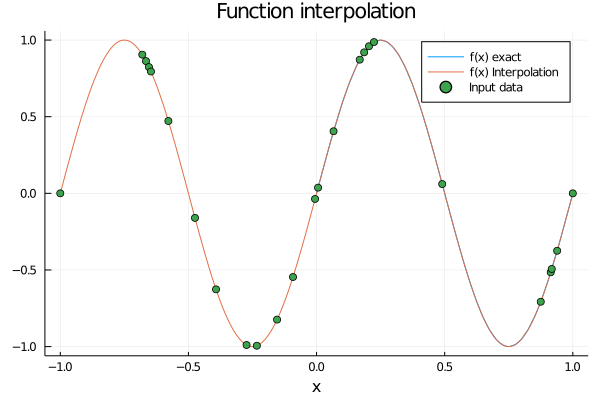

In [16]:
# Actual function and its derivatives
f(x) = sin(2π * x)
f′(x) = 2π * cos(2π * x)
f′′(x) = -4π^2 * sin(2π * x)

# Generate uneven grid of ``N`` points in ``[-1, 1]``
N = 25
rng = MersenneTwister(42)
x = sort!(2rand(rng, N) .- 1)
x[1] = -1; x[end] = 1;  # make sure endpoints are included
y = f.(x)               # actual function at the random grid points

# Now create the rational approximation
modl = aaa(x, y)

M = 129
pts = chebyshevpoints(M)
S = Chebyshev()

# The Fun and its first two derivatives
nfun = Fun(S, ApproxFun.transform(S, modl.(pts)))
D′  = nfun'
D′′ = nfun''

xplot = -1:0.01:1
plt = plot(f, 0, 1; label = "f(x) exact", xlabel = "x", title = "Function interpolation")
plot!(plt, xplot, nfun.(xplot); label = "f(x) Interpolation")
scatter!(plt, x, y; label = "Input data")

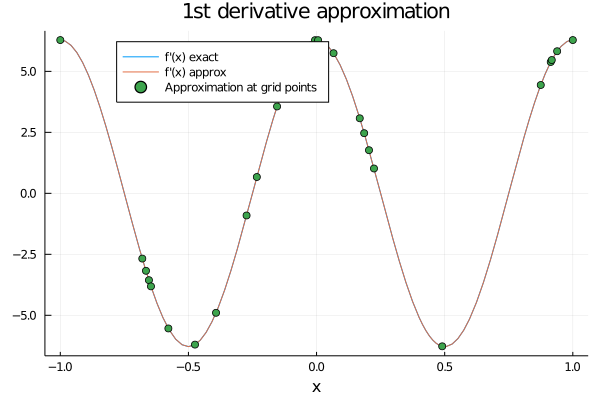

In [17]:
plt = plot(f′, -1, 1; label = "f'(x) exact",  xlabel = "x", legend = :top, title = "1st derivative approximation")
plot!(plt, D′, -1, 1; label = "f'(x) approx")
scatter!(plt, x, D′.(x); label = "Approximation at grid points")

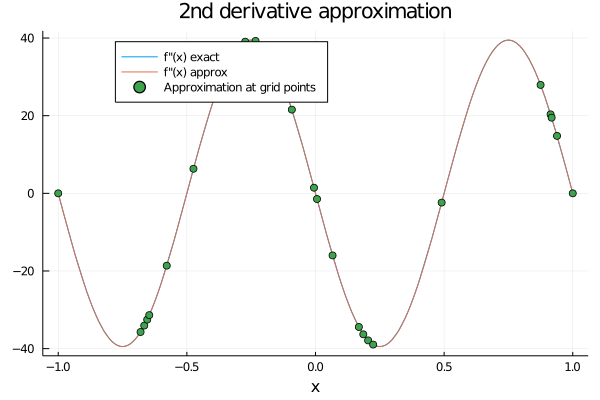

In [18]:
plt = plot(f′′, -1, 1; label = "f''(x) exact", xlabel = "x", legend = :top, title = "2nd derivative approximation")
plot!(plt, xplot, D′′.(xplot); label = "f''(x) approx")
scatter!(plt, x, D′′.(x); label = "Approximation at grid points")

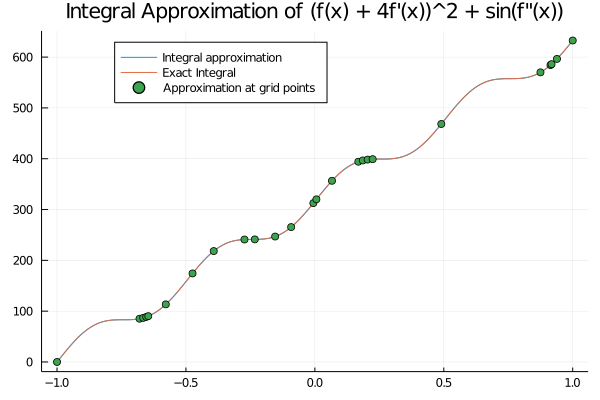

In [19]:
# A 'complicated' function of f(x), f'(x), and f''(x) from the random grid approximation
G = (nfun + 4*D′)^2 + sin(D′′)

# and its integral
Gint = cumsum(G)

# Now compare to the 'exact' integral
fz = sin(2pi * Fun())
GE = (fz + 4*fz')^2 + sin(fz'')
GEint = cumsum(GE)

plt = plot(xplot, Gint.(xplot); label = "Integral approximation", legend = :top, title="Integral Approximation of (f(x) + 4f'(x))^2 + sin(f''(x))")
plot!(plt, xplot, GEint.(xplot); label = "Exact Integral")
scatter!(plt, x, Gint.(x); label = "Approximation at grid points")

In [20]:
# We know that "converged to the eye" is not good enough so check the error norm too
norm(GEint - Gint)

2.4179153218719304e-6

So not too bad after all.